In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import re

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

hp='/mnt/stsi/stsi0/raqueld/imputator/autoencoder_tuning_pipeline/1000_random_hyperparameters.tsv'
extended_hp='/mnt/stsi/stsi0/raqueld/imputator/autoencoder_tuning_pipeline/500000_random_hyperparameters.tsv'
nvar='/mnt/stsi/stsi0/raqueld/imputator/autoencoder_tuning_pipeline/NVAR_per_MAF_bin'
r2s='/mnt/stsi/stsi0/raqueld/imputator/autoencoder_tuning_pipeline/mean_r2_pop.txt'

In [2]:
#hp_data = np.genfromtxt(fname=hp, delimiter="\t", skip_header=0, names=True)
hp_data = pd.read_csv(hp,sep="\t")
extended_hp_data = pd.read_csv(extended_hp,sep="\t")

hp_data = pd.concat([hp_data, extended_hp_data])

nvar_data = pd.read_csv(nvar,sep="\t",index_col=False, header=None, names=["FILE","(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]"])
#del nvar_data['FILE']
r2s_data = pd.read_csv(r2s,sep="\t",index_col=False, header=None, names=hp_data['#model_id'][0:100])

In [3]:
print(nvar_data.shape)
nvar_data

(256, 12)


,FILE,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]"
0,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17274081-...,0.092659,0.404134,0.121882,0.130435,0.033500,0.057021,0.013542,0.039202,0.056308,0.003564,0.047755
1,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17365233-...,0.086598,0.426804,0.113402,0.144330,0.030928,0.039175,0.032990,0.037113,0.030928,0.041237,0.016495
2,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17412748-...,0.080950,0.347998,0.113066,0.168060,0.045755,0.079190,0.032996,0.062912,0.032556,0.019798,0.016718
3,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17578285-...,0.083276,0.355631,0.085324,0.156314,0.036177,0.060068,0.038225,0.054608,0.073720,0.038225,0.018430
4,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17674645-...,0.119186,0.337209,0.104651,0.133721,0.029070,0.087209,0.049419,0.049419,0.014535,0.017442,0.058140
...,...,...,...,...,...,...,...,...,...,...,...,...
251,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50108709-...,0.089640,0.359981,0.101939,0.189451,0.040208,0.069536,0.054163,0.055818,0.036424,0.002365,0.000473
252,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,0.020052,0.030401,0.014877,0.045278
253,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,0.058303,0.065331,0.020562,0.023946
254,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,0.026286,0.028286,0.040000,0.018000


In [4]:
print(hp_data.shape)
hp_data

(501000, 14)


,#model_id,l1,l2,beta,rho,gamma,disable_alpha,learn_rate,activation,optimizer,loss_type,n_layers,size_ratio,decay_rate
0,model_1,1.000000e-07,1.000000e-08,0.0001,0.050,0.0,1,0.00100,leakyrelu,rmsprop,FL,8,0.7,0.50
1,model_2,0.000000e+00,1.000000e-02,0.0000,0.500,4.0,1,0.01000,leakyrelu,rmsprop,CE,6,0.9,0.25
2,model_3,1.000000e-01,1.000000e-07,0.1000,0.500,1.0,0,0.10000,tanh,rmsprop,CE,8,1.0,0.25
3,model_4,1.000000e-05,1.000000e-02,1.0000,0.500,5.0,1,0.00001,leakyrelu,adadelta,CE,8,0.8,0.95
4,model_5,0.000000e+00,1.000000e-05,0.0000,0.005,0.0,1,0.00010,relu,adam,CE,4,0.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,model_500996,1.000000e-02,0.000000e+00,0.0001,0.005,0.5,1,0.01000,relu,adam,FL,6,0.2,0.00
499996,model_500997,0.000000e+00,1.000000e-01,0.0010,0.500,0.0,1,0.00001,tanh,adam,FL,8,0.5,0.75
499997,model_500998,1.000000e-08,1.000000e-07,0.1000,0.050,4.0,1,0.10000,tanh,sgd,CE,2,0.9,0.25
499998,model_500999,1.000000e-03,1.000000e-05,0.0010,0.050,5.0,0,0.00010,relu,adadelta,FL,2,0.9,0.95


In [5]:
print(r2s_data.shape)
r2s_data

(256, 100)


,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,...,model_91,model_92,model_93,model_94,model_95,model_96,model_97,model_98,model_99,model_100
0,0.117721,0.005714,0.000000,0.014596,0.193800,0.004243,0.026460,0.0,0.049099,0.000000,...,0.004478,0.014229,0.015059,0.003933,0.004864,0.028335,0.030055,0.029014,0.003220,0.002822
1,0.041652,0.008651,0.000168,0.011131,0.103835,0.003975,0.021146,NaN,0.008285,0.001864,...,0.006443,0.004995,0.012028,0.006484,0.008254,0.022467,0.018999,0.021858,0.005890,0.003411
2,0.068386,0.017298,0.000000,0.008022,0.190235,0.004571,0.016748,0.0,0.011665,0.000000,...,0.013031,0.003079,0.008164,0.007710,0.008457,0.016683,0.016356,0.017136,0.010912,0.011544
3,0.065725,0.008365,0.000000,0.008527,0.185116,0.002648,0.016085,0.0,0.027839,0.000000,...,0.002517,0.003865,0.007533,0.002002,0.007424,0.017112,0.016809,0.016250,0.003027,0.003212
4,0.059619,0.018963,0.000000,0.015038,0.108487,0.002581,0.032244,0.0,0.000687,0.005310,...,0.003727,0.004782,0.011699,0.059999,0.002881,0.031725,0.031265,0.039824,0.012052,0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.032882,0.000408,0.000000,0.015743,0.169929,0.063440,0.034945,NaN,0.092633,0.000000,...,0.076119,0.087656,0.015515,0.048025,0.018373,0.037486,0.038516,0.039095,0.068895,0.022446
252,0.058854,0.004899,0.000000,0.008316,0.147670,0.000444,0.017570,0.0,0.034039,0.001342,...,0.002223,0.002703,0.007752,0.002478,0.003076,0.017912,0.018362,0.020507,0.005092,0.003701
253,0.024431,0.043880,0.000100,0.010724,0.201321,0.015041,0.024157,0.0,0.100228,0.000000,...,0.004747,0.076183,0.010855,0.005531,0.009297,0.026307,0.024882,0.027277,0.004525,0.003703
254,0.046217,0.001735,0.000000,0.007211,0.124648,0.005505,0.017677,0.0,0.038830,0.000000,...,0.008280,0.043567,0.007608,0.008625,0.003591,0.018948,0.019406,0.019328,0.007844,0.005772


In [6]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
r2s_data.iloc[:,:] = imputer.fit_transform(r2s_data)

In [7]:
hp_data_repeated = pd.concat([hp_data.iloc[0:100,:]]*256, ignore_index=True).sort_values(by='#model_id').reset_index()
nvar_data_repeated = pd.concat([nvar_data]*100, ignore_index=True)

In [8]:
hp_data_repeated

,index,#model_id,l1,l2,beta,rho,gamma,disable_alpha,learn_rate,activation,optimizer,loss_type,n_layers,size_ratio,decay_rate
0,0,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
1,11400,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
2,18400,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
3,5400,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
4,3100,model_1,1.000000e-07,1.000000e-08,0.0001,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,22798,model_99,0.000000e+00,0.000000e+00,0.0000,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25596,13498,model_99,0.000000e+00,0.000000e+00,0.0000,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25597,15998,model_99,0.000000e+00,0.000000e+00,0.0000,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25598,18998,model_99,0.000000e+00,0.000000e+00,0.0000,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75


In [9]:
nvar_data_repeated

,FILE,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.5]"
0,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17274081-...,0.092659,0.404134,0.121882,0.130435,0.033500,0.057021,0.013542,0.039202,0.056308,0.003564,0.047755
1,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17365233-...,0.086598,0.426804,0.113402,0.144330,0.030928,0.039175,0.032990,0.037113,0.030928,0.041237,0.016495
2,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17412748-...,0.080950,0.347998,0.113066,0.168060,0.045755,0.079190,0.032996,0.062912,0.032556,0.019798,0.016718
3,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17578285-...,0.083276,0.355631,0.085324,0.156314,0.036177,0.060068,0.038225,0.054608,0.073720,0.038225,0.018430
4,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17674645-...,0.119186,0.337209,0.104651,0.133721,0.029070,0.087209,0.049419,0.049419,0.014535,0.017442,0.058140
...,...,...,...,...,...,...,...,...,...,...,...,...
25595,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50108709-...,0.089640,0.359981,0.101939,0.189451,0.040208,0.069536,0.054163,0.055818,0.036424,0.002365,0.000473
25596,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,0.020052,0.030401,0.014877,0.045278
25597,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,0.058303,0.065331,0.020562,0.023946
25598,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,0.026286,0.028286,0.040000,0.018000


In [10]:
nvar_hp = pd.concat([nvar_data_repeated, hp_data_repeated], axis=1)

In [11]:
print(nvar_hp.shape)
nvar_hp

(25600, 27)


,FILE,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]",...,rho,gamma,disable_alpha,learn_rate,activation,optimizer,loss_type,n_layers,size_ratio,decay_rate
0,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17274081-...,0.092659,0.404134,0.121882,0.130435,0.033500,0.057021,0.013542,0.039202,0.056308,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
1,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17365233-...,0.086598,0.426804,0.113402,0.144330,0.030928,0.039175,0.032990,0.037113,0.030928,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
2,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17412748-...,0.080950,0.347998,0.113066,0.168060,0.045755,0.079190,0.032996,0.062912,0.032556,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
3,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17578285-...,0.083276,0.355631,0.085324,0.156314,0.036177,0.060068,0.038225,0.054608,0.073720,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
4,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17674645-...,0.119186,0.337209,0.104651,0.133721,0.029070,0.087209,0.049419,0.049419,0.014535,...,0.05,0.0,1,0.001,leakyrelu,rmsprop,FL,8,0.7,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50108709-...,0.089640,0.359981,0.101939,0.189451,0.040208,0.069536,0.054163,0.055818,0.036424,...,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25596,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,0.020052,0.030401,...,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25597,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,0.058303,0.065331,...,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75
25598,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,0.026286,0.028286,...,0.25,4.0,0,0.100,leakyrelu,adadelta,FL,4,0.2,0.75


In [12]:
nvar_hp_one_hot = pd.get_dummies(nvar_hp, columns=['activation','optimizer', 'loss_type'], prefix='one_hot')
del nvar_hp_one_hot['index']
del nvar_hp_one_hot['#model_id']
del nvar_hp_one_hot['FILE']

nvar_hp_one_hot['r2'] = r2s_data.values.flatten('F')

In [13]:
nvar_hp_one_hot.columns.values

array(['(0.0, 0.0001]', '(0.0001, 0.0005]', '(0.0005, 0.001]',
       '(0.001, 0.005]', '(0.005, 0.01]', '(0.01, 0.05]', '(0.05, 0.1]',
       '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', 'l1', 'l2',
       'beta', 'rho', 'gamma', 'disable_alpha', 'learn_rate', 'n_layers',
       'size_ratio', 'decay_rate', 'one_hot_leakyrelu', 'one_hot_relu',
       'one_hot_sigmoid', 'one_hot_tanh', 'one_hot_adadelta',
       'one_hot_adagrad', 'one_hot_adam', 'one_hot_rmsprop',
       'one_hot_sgd', 'one_hot_CE', 'one_hot_FL', 'r2'], dtype=object)

In [14]:
nvar_hp_one_hot

,"(0.0, 0.0001]","(0.0001, 0.0005]","(0.0005, 0.001]","(0.001, 0.005]","(0.005, 0.01]","(0.01, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 0.4]",...,one_hot_sigmoid,one_hot_tanh,one_hot_adadelta,one_hot_adagrad,one_hot_adam,one_hot_rmsprop,one_hot_sgd,one_hot_CE,one_hot_FL,r2
0,0.092659,0.404134,0.121882,0.130435,0.033500,0.057021,0.013542,0.039202,0.056308,0.003564,...,0,0,0,0,0,1,0,0,1,0.117721
1,0.086598,0.426804,0.113402,0.144330,0.030928,0.039175,0.032990,0.037113,0.030928,0.041237,...,0,0,0,0,0,1,0,0,1,0.041652
2,0.080950,0.347998,0.113066,0.168060,0.045755,0.079190,0.032996,0.062912,0.032556,0.019798,...,0,0,0,0,0,1,0,0,1,0.068386
3,0.083276,0.355631,0.085324,0.156314,0.036177,0.060068,0.038225,0.054608,0.073720,0.038225,...,0,0,0,0,0,1,0,0,1,0.065725
4,0.119186,0.337209,0.104651,0.133721,0.029070,0.087209,0.049419,0.049419,0.014535,0.017442,...,0,0,0,0,0,1,0,0,1,0.059619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,0.089640,0.359981,0.101939,0.189451,0.040208,0.069536,0.054163,0.055818,0.036424,0.002365,...,0,0,1,0,0,0,0,0,1,0.022446
25596,0.109314,0.383570,0.084735,0.205045,0.044631,0.042044,0.020052,0.020052,0.030401,0.014877,...,0,0,1,0,0,0,0,0,1,0.003701
25597,0.102290,0.352941,0.099948,0.140031,0.040604,0.076262,0.019781,0.058303,0.065331,0.020562,...,0,0,1,0,0,0,0,0,1,0.003703
25598,0.105714,0.377143,0.120571,0.160286,0.038857,0.066857,0.018000,0.026286,0.028286,0.040000,...,0,0,1,0,0,0,0,0,1,0.005772


In [15]:
nvar_hp_one_hot_normalized = nvar_hp_one_hot.copy()
# apply normalization techniques 
for column in nvar_hp_one_hot_normalized.columns: 
    nvar_hp_one_hot_normalized[column] = nvar_hp_one_hot[column]  / nvar_hp_one_hot[column].abs().max() 

In [16]:
X = pd.DataFrame(nvar_hp_one_hot.iloc[:,:-1])
y = pd.DataFrame(nvar_hp_one_hot['r2'])

lmodel = LinearRegression()
xmodel = xgb.XGBRegressor(random_state = 123)
rmodel = RandomForestRegressor(n_estimators = 100, random_state = 123)

lscores = []
xscores = []
rscores = []
ly_preds = []
y_trues = []
xy_preds = []
ry_preds = []

#clean column labels, required for xgboost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

kfold = KFold(n_splits = 10, shuffle = True, random_state = 123)

for i, (train, test) in enumerate(kfold.split(X, y)):
    print("Iteration", i)
    lmodel.fit(X.iloc[train,:], y.iloc[train,:])
    xmodel.fit(X.iloc[train,:], np.asarray(y.iloc[train,:]).flatten())
    rmodel.fit(X.iloc[train,:], np.asarray(y.iloc[train,:]).flatten())
    lscore = lmodel.score(X.iloc[test,:], y.iloc[test,:])
    xscore = xmodel.score(X.iloc[test,:], np.asarray(y.iloc[test,:]))
    rscore = rmodel.score(X.iloc[test,:], np.asarray(y.iloc[test,:]))
    #score = r2_score(np.array(y.iloc[test,:]).flatten(), lmodel.predict(X.iloc[test,:]).flatten())
    y_trues += list(np.array(y.iloc[test,:]).flatten())
    ly_preds += list(lmodel.predict(X.iloc[test,:]).flatten())
    xy_preds += list(xmodel.predict(X.iloc[test,:]).flatten())
    ry_preds += list(rmodel.predict(X.iloc[test,:]).flatten())

    lscores.append(lscore)
    #score = r2_score(np.array(y.iloc[test,:]).flatten(), xmodel.predict(X.iloc[test,:]).flatten())
    xscores.append(xscore)
    rscores.append(rscore)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9


[0.12147962445616522, 0.14191031775930074, 0.15314666328724624, 0.11432811008531774, 0.09378546824100686, 0.11356069262550395, 0.1542357757078483, 0.12460868637182887, 0.1123298940365195, 0.13908573436597804]


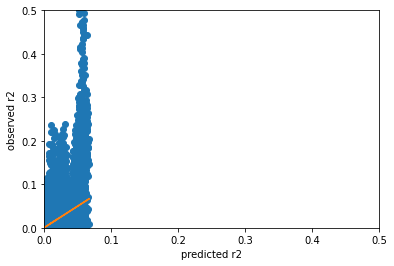

In [17]:
#create basic scatterplot
plt.plot(ly_preds, y_trues, 'o')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(ly_preds, y_trues, 1)
slope = m*np.asarray(ly_preds)+b
#add linear regression line to scatterplot 
plt.plot(ly_preds, slope)
plt.xlabel('predicted r2')
plt.ylabel('observed r2')
plt.xlim([0,0.5])
plt.ylim([0,0.5])
print(lscores)

[0.7917069688546383, 0.800640027190965, 0.78062052280605, 0.7789874570924189, 0.7520216852115329, 0.7484407048962745, 0.8040910533018123, 0.7544096531985449, 0.7198063728461478, 0.7874699041923339]


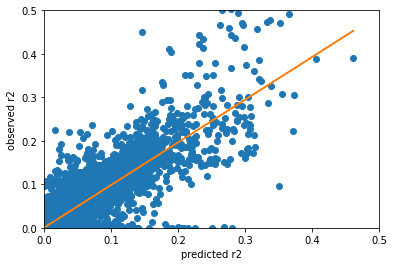

In [18]:
#create basic scatterplot
plt.plot(xy_preds, y_trues, 'o')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(xy_preds, y_trues, 1)
slope = m*np.asarray(xy_preds)+b
#add linear regression line to scatterplot 
plt.plot(xy_preds, slope)
plt.xlabel('predicted r2')
plt.ylabel('observed r2')
plt.xlim([0,0.5])
plt.ylim([0,0.5])
print(xscores)

[0.7550082902230917, 0.7882773783329925, 0.753558134384889, 0.7612740609852146, 0.7156570640726733, 0.722038987449924, 0.788869468279068, 0.7065071222248247, 0.6639053778964273, 0.7506149991421865]


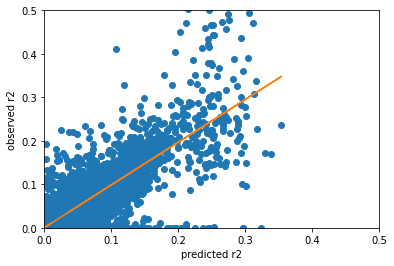

In [19]:
#create basic scatterplot
plt.plot(ry_preds, y_trues, 'o')
#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(ry_preds, y_trues, 1)
slope = m*np.asarray(ry_preds)+b
#add linear regression line to scatterplot 
plt.plot(ry_preds, slope)
plt.xlabel('predicted r2')
plt.ylabel('observed r2')
plt.xlim([0,0.5])
plt.ylim([0,0.5])
print(rscores)

In [20]:
'''
full_hp_data_repeated = pd.concat([hp_data]*256, ignore_index=True).sort_values(by='#model_id').reset_index()
full_nvar_data_repeated = pd.concat([nvar_data]*1000, ignore_index=True)
full_nvar_hp = pd.concat([full_nvar_data_repeated, full_hp_data_repeated], axis=1)

full_nvar_hp_one_hot = pd.get_dummies(full_nvar_hp, columns=['activation','optimizer', 'loss_type'], prefix='one_hot')
del full_nvar_hp_one_hot['index']
del full_nvar_hp_one_hot['#model_id']
del full_nvar_hp_one_hot['FILE']

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
full_nvar_hp_one_hot.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in full_nvar_hp_one_hot.columns.values]
full_nvar_hp['r2_pred'] = xmodel.predict(full_nvar_hp_one_hot)
'''

'\nfull_hp_data_repeated = pd.concat([hp_data]*256, ignore_index=True).sort_values(by=\'#model_id\').reset_index()\nfull_nvar_data_repeated = pd.concat([nvar_data]*1000, ignore_index=True)\nfull_nvar_hp = pd.concat([full_nvar_data_repeated, full_hp_data_repeated], axis=1)\n\nfull_nvar_hp_one_hot = pd.get_dummies(full_nvar_hp, columns=[\'activation\',\'optimizer\', \'loss_type\'], prefix=\'one_hot\')\ndel full_nvar_hp_one_hot[\'index\']\ndel full_nvar_hp_one_hot[\'#model_id\']\ndel full_nvar_hp_one_hot[\'FILE\']\n\nregex = re.compile(r"\\[|\\]|<", re.IGNORECASE)\nfull_nvar_hp_one_hot.columns = [regex.sub("_", col) if any(x in str(col) for x in set((\'[\', \']\', \'<\'))) else col for col in full_nvar_hp_one_hot.columns.values]\nfull_nvar_hp[\'r2_pred\'] = xmodel.predict(full_nvar_hp_one_hot)\n'

In [21]:
#FULL MODEL TRAIN
xmodel.fit(X, np.asarray(y).flatten())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
#find best model per chunk
chunk_size = 25000
n = hp_data.shape[0]
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

vmvs = []
bests = []
r2s = []

for i in range(0, n, chunk_size):
    print(i, "Predicting accuracy for chunk...")
    full_hp_data_repeated_chunk = pd.concat([hp_data.iloc[i:i+chunk_size,:]]*256, ignore_index=True).sort_values(by='#model_id').reset_index()
    full_nvar_data_repeated_chunk = pd.concat([nvar_data]*chunk_size, ignore_index=True)
    full_nvar_hp_chunk = pd.concat([full_nvar_data_repeated_chunk, full_hp_data_repeated_chunk], axis=1)
    
    full_nvar_hp_one_hot_chunk = pd.get_dummies(full_nvar_hp_chunk, columns=['activation','optimizer', 'loss_type'], prefix='one_hot')
    del full_nvar_hp_one_hot_chunk['index']
    del full_nvar_hp_one_hot_chunk['#model_id']
    del full_nvar_hp_one_hot_chunk['FILE']
    
    full_nvar_hp_one_hot_chunk.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in full_nvar_hp_one_hot_chunk.columns.values]
    
    full_nvar_hp_chunk['r2_pred'] = xmodel.predict(full_nvar_hp_one_hot_chunk)
    
    print(i, "Extracting best model from hp chunk...")
    for vmv in nvar_data['FILE']:
        vmv_data = full_nvar_hp_chunk.loc[full_nvar_hp_chunk['FILE'] == vmv]
        max_r2 = vmv_data['r2_pred'].max()
        best = vmv_data.loc[vmv_data['r2_pred'] == max_r2]
        vmvs.append(vmv)
        bests.append(best)
        r2s.append(max_r2)
        
result = pd.concat(bests)
summary = pd.DataFrame([vmvs, result['#model_id'], r2s]).transpose()

0 Predicting accuracy for chunk...
0 Extracting best model from hp chunk...
25000 Predicting accuracy for chunk...
25000 Extracting best model from hp chunk...
50000 Predicting accuracy for chunk...
50000 Extracting best model from hp chunk...
75000 Predicting accuracy for chunk...
75000 Extracting best model from hp chunk...
100000 Predicting accuracy for chunk...
100000 Extracting best model from hp chunk...
125000 Predicting accuracy for chunk...
125000 Extracting best model from hp chunk...
150000 Predicting accuracy for chunk...
150000 Extracting best model from hp chunk...
175000 Predicting accuracy for chunk...
175000 Extracting best model from hp chunk...
200000 Predicting accuracy for chunk...
200000 Extracting best model from hp chunk...
225000 Predicting accuracy for chunk...
225000 Extracting best model from hp chunk...
250000 Predicting accuracy for chunk...
250000 Extracting best model from hp chunk...
275000 Predicting accuracy for chunk...
275000 Extracting best model f

In [23]:
#merge chunks and find the overall best
vmvs = []
bests = []
r2s = []
print(result.shape)
for vmv in result['FILE'].unique():
    vmv_data = result.loc[result['FILE'] == vmv]
    max_r2 = vmv_data['r2_pred'].max()
    best = vmv_data.loc[vmv_data['r2_pred'] == max_r2]
    vmvs.append(vmv)
    bests.append(best)
    r2s.append(max_r2)
result = pd.concat(bests)
summary = pd.DataFrame([vmvs, result['#model_id'], r2s]).transpose()
print(result.shape)

(5376, 28)
(256, 28)


In [24]:
'''
vmvs = []
bests = []
r2s = []
for vmv in full_nvar_hp['FILE'].unique():
    vmv_data = full_nvar_hp.loc[full_nvar_hp['FILE'] == vmv]
    max_r2 = vmv_data['r2_pred'].max()
    best = vmv_data.loc[vmv_data['r2_pred'] == max_r2]
    vmvs.append(vmv)
    bests.append(best)
    r2s.append(max_r2)
result = pd.concat(bests)
summary = pd.DataFrame([vmvs, result['#model_id'], r2s]).transpose()
'''

"\nvmvs = []\nbests = []\nr2s = []\nfor vmv in full_nvar_hp['FILE'].unique():\n    vmv_data = full_nvar_hp.loc[full_nvar_hp['FILE'] == vmv]\n    max_r2 = vmv_data['r2_pred'].max()\n    best = vmv_data.loc[vmv_data['r2_pred'] == max_r2]\n    vmvs.append(vmv)\n    bests.append(best)\n    r2s.append(max_r2)\nresult = pd.concat(bests)\nsummary = pd.DataFrame([vmvs, result['#model_id'], r2s]).transpose()\n"

In [25]:
result.to_csv('best_hyperparameters_from_500000_xgb.tsv', sep = '\t', index=False)
summary.to_csv('summary_from_500000_xgb.tsv', sep = '\t', index=False)

In [26]:
import decimal
decimal.getcontext().prec = 20

hp_labels = ['model_id','l1', 'l2', 'beta', 'rho', 'gamma', 'disable_alpha',
             'learn_rate', 'activation', 'optimizer', 'loss_type', 'n_layers',
             'size_ratio', 'decay_rate']

root_dir='/mnt/stsi/stsi0/raqueld/VMV_VCF_Extractions/chr22/'

i=0
with open('best_hyperparameters_from_500000_xgb.sh', 'w') as file_object:
    for index, row in result.iterrows():
        nvar=0
        i=i+1
        if i % 20 == 0:
            print(i)
        with open(root_dir+row['FILE']) as vmv_file:
            for line in vmv_file:
                if not line.startswith('#'):
                    nvar+=1
        hps=row.iloc[13:-1]
        cmd="CUDA_VISIBLE_DEVICES=<my_GPU_id> python3 DSAE_TORCH_ARG.py --min_mask 0.80 --max_mask "+str(decimal.Decimal(nvar-5)/decimal.Decimal(nvar))+" --input "+row['FILE']
        for label, value in zip(hp_labels, hps):
            cmd+=" --"+label+" "+str(value)
        #print(cmd+" --resume 1")
        file_object.write(cmd+" --resume 1 --max_epochs 50000\n")


20
40
60
80
100
120
140
160
180
200
220
240


In [27]:
summary

,0,1,2
0,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17274081-...,model_444800,0.248687
1,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17365233-...,model_475870,0.140011
2,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17412748-...,model_410631,0.263308
3,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17578285-...,model_410631,0.272239
4,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.17674645-...,model_345064,0.207816
...,...,...,...
251,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50108709-...,model_358014,0.280122
252,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,model_336563,0.246048
253,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,model_504,0.321898
254,HRC.r1-1.EGA.GRCh37.chr22.haplotypes.50350213-...,model_255745,0.260811


In [28]:
np.unique(result['#model_id'])

array(['model_105650', 'model_111410', 'model_112108', 'model_112922',
       'model_114120', 'model_115361', 'model_116438', 'model_118884',
       'model_125897', 'model_127034', 'model_134092', 'model_13511',
       'model_145900', 'model_150111', 'model_151596', 'model_156321',
       'model_156998', 'model_159349', 'model_161233', 'model_16976',
       'model_180001', 'model_183606', 'model_186455', 'model_187914',
       'model_190663', 'model_198846', 'model_201770', 'model_202535',
       'model_203035', 'model_226024', 'model_226133', 'model_231256',
       'model_233563', 'model_233910', 'model_234945', 'model_238015',
       'model_239182', 'model_239625', 'model_241595', 'model_243762',
       'model_252702', 'model_255745', 'model_257537', 'model_259028',
       'model_269368', 'model_273262', 'model_275433', 'model_276172',
       'model_28218', 'model_288921', 'model_29942', 'model_302760',
       'model_310748', 'model_311263', 'model_313590', 'model_323577',
       'mo

In [29]:
len(np.unique(result['#model_id']))

132

In [30]:
unique, frequency = np.unique(result['#model_id'],  
                              return_counts = True) 

In [31]:
pd.DataFrame([unique,frequency]).transpose()

,0,1
0,model_105650,1
1,model_111410,3
2,model_112108,2
3,model_112922,1
4,model_114120,1
...,...,...
127,model_66475,1
128,model_74914,1
129,model_76908,1
130,model_79753,1


In [32]:
feature_names = list(full_nvar_hp_one_hot_chunk.columns)

In [33]:
import shap
shap.initjs()
shap_values = shap.TreeExplainer(xmodel).shap_values(X)


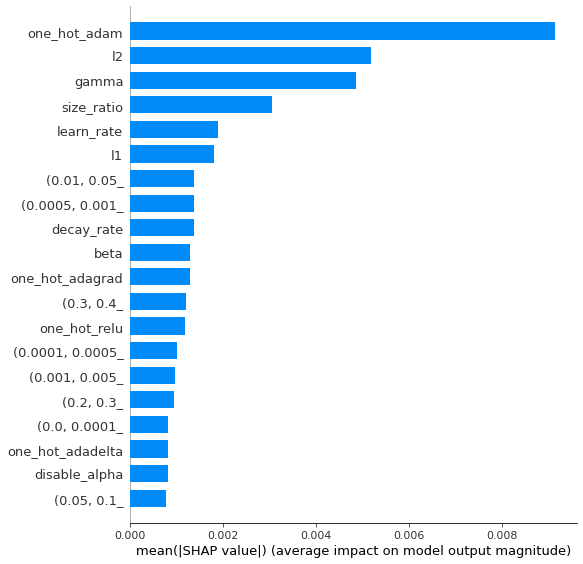

In [34]:
shap.summary_plot(shap_values, X, plot_type="bar")


In [35]:
shap_interaction_values = shap.TreeExplainer(xmodel).shap_interaction_values(X)

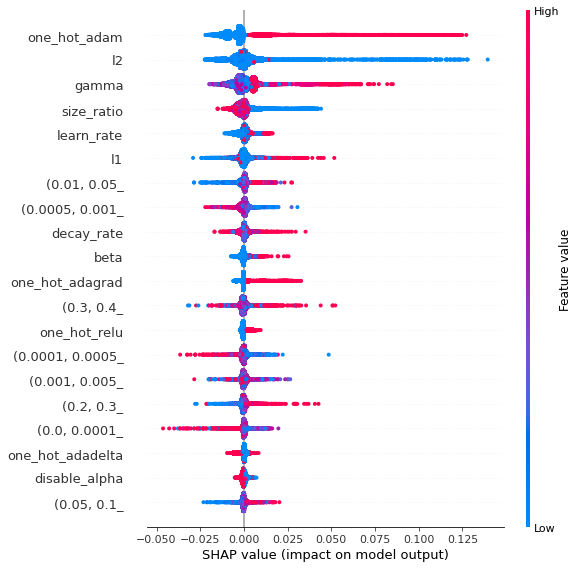

In [36]:
shap.summary_plot(shap_values, X)

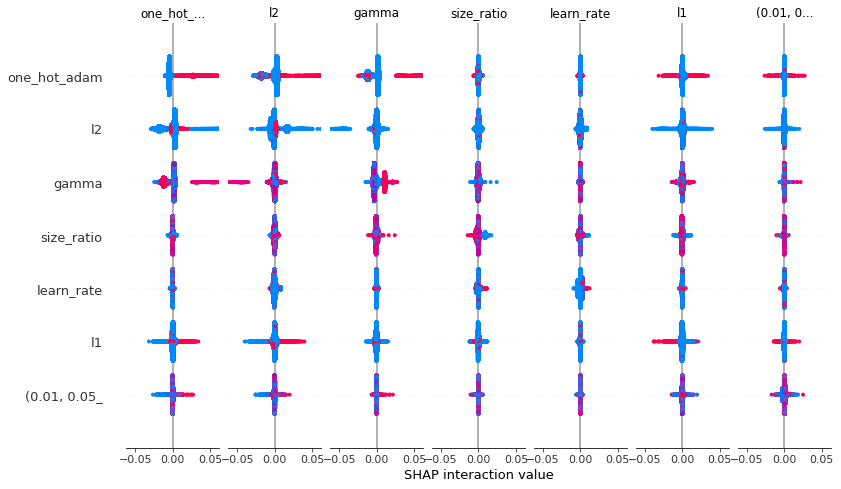

In [37]:
shap.summary_plot(shap_interaction_values, X, plot_type="bar")